# Sample Code of PertMap (Perturbation-based Saliency Map)

### PertMap generates a heatmap where the CNN has focused on.

* Satoshi Hara, Kouichi Ikeno, Tasuku Soma, Takanori Maehara. [Maximally Invariant Data Perturbation as Explanation]((https://arxiv.org/abs/1806.07004)). arXiv:1806.07004, 2018.

### The example below generates a heatmap for VGG16.

In [1]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.externals import joblib
import tensorflow as tf
import skimage
import skimage.io
import skimage.transform
VGG_MEAN = [103.939, 116.779, 123.68]

## Setup VGG16

#### To begin with, download the weight file of VGG16 from the link in [this repository](https://github.com/machrisaa/tensorflow-vgg).
We use the VGG16 implementation in the repository, also.

In [2]:
def get_conv_filter(data_dict, name):
    return tf.constant(data_dict[name][0], name="filter")
    
def get_bias(data_dict, name):
    return tf.constant(data_dict[name][1], name="biases")

def get_fc_weight(data_dict, name):
    return tf.constant(data_dict[name][0], name="weights")

In [3]:
def max_pool(bottom, name):
    return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

def conv_layer(bottom, data_dict, name):
    with tf.variable_scope(name):
        filt = get_conv_filter(data_dict, name)
        conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')
        conv_biases = get_bias(data_dict, name)
        bias = tf.nn.bias_add(conv, conv_biases)
        relu = tf.nn.relu(bias)
        return relu

def fc_layer(bottom, data_dict, name):
    with tf.variable_scope(name):
        shape = bottom.get_shape().as_list()
        dim = 1
        for d in shape[1:]:
            dim *= d
        x = tf.reshape(bottom, [-1, dim])
        weights = get_fc_weight(data_dict, name)
        biases = get_bias(data_dict, name)
        fc = tf.nn.bias_add(tf.matmul(x, weights), biases)
        return fc

In [4]:
def build(graph, image):
    layer = {}
    data_dict = np.load('./vgg16.npy', encoding='latin1').item()
    with graph.as_default():
        layer['image'] = image
        rgb_scaled = image * 255.0

        # Convert RGB to BGR
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=rgb_scaled)
        assert red.get_shape().as_list()[1:] == [224, 224, 1]
        assert green.get_shape().as_list()[1:] == [224, 224, 1]
        assert blue.get_shape().as_list()[1:] == [224, 224, 1]
        bgr = tf.concat(axis=3, values=[
            blue - VGG_MEAN[0],
            green - VGG_MEAN[1],
            red - VGG_MEAN[2],
        ])
        assert bgr.get_shape().as_list()[1:] == [224, 224, 3]

        # layer-1
        conv1_1 = conv_layer(bgr, data_dict, 'conv1_1')
        conv1_2 = conv_layer(conv1_1, data_dict, 'conv1_2')
        pool1 = max_pool(conv1_2, 'pool1')
        layer['conv1_1'] = conv1_1
        layer['conv1_2'] = conv1_2
        layer['pool1'] = pool1

        # layer-2
        conv2_1 = conv_layer(pool1, data_dict, 'conv2_1')
        conv2_2 = conv_layer(conv2_1, data_dict, 'conv2_2')
        pool2 = max_pool(conv2_2, 'pool2')
        layer['conv2_1'] = conv2_1
        layer['conv2_2'] = conv2_2
        layer['pool2'] = pool2
        
        # layer-3
        conv3_1 = conv_layer(pool2, data_dict, 'conv3_1')
        conv3_2 = conv_layer(conv3_1, data_dict, 'conv3_2')
        conv3_3 = conv_layer(conv3_2, data_dict, 'conv3_3')
        pool3 = max_pool(conv3_3, 'pool3')
        layer['conv3_1'] = conv3_1
        layer['conv3_2'] = conv3_2
        layer['conv3_3'] = conv3_3
        layer['pool3'] = pool3

        # layer-4
        conv4_1 = conv_layer(pool3, data_dict, 'conv4_1')
        conv4_2 = conv_layer(conv4_1, data_dict, 'conv4_2')
        conv4_3 = conv_layer(conv4_2, data_dict, 'conv4_3')
        pool4 = max_pool(conv4_3, 'pool4')
        layer['conv4_1'] = conv4_1
        layer['conv4_2'] = conv4_2
        layer['conv4_3'] = conv4_3
        layer['pool4'] = pool4

        # layer-5
        conv5_1 = conv_layer(pool4, data_dict, 'conv5_1')
        conv5_2 = conv_layer(conv5_1, data_dict, 'conv5_2')
        conv5_3 = conv_layer(conv5_2, data_dict, 'conv5_3')
        pool5 = max_pool(conv5_3, 'pool5')
        layer['conv5_1'] = conv5_1
        layer['conv5_2'] = conv5_2
        layer['conv5_3'] = conv5_3
        layer['pool5'] = pool5

        # layer-6
        fc6 = fc_layer(pool5, data_dict, 'fc6')
        assert fc6.get_shape().as_list()[1:] == [4096]
        relu6 = tf.nn.relu(fc6)
        layer['fc6'] = fc6
        layer['relu6'] = relu6

        # layer-7
        fc7 = fc_layer(relu6, data_dict, 'fc7')
        relu7 = tf.nn.relu(fc7)
        layer['fc7'] = fc7
        layer['relu7'] = relu7

        # layer-8
        fc8 = fc_layer(relu7, data_dict, 'fc8')
        prob = tf.nn.softmax(fc8, name='prob')
        layer['fc8'] = fc8
        layer['prob'] = prob
    return layer

## Load Image

Use a sample image from [here](https://www.pexels.com/search/dog/).

In [5]:
%%capture

# download image
!wget 'https://images.pexels.com/photos/58997/pexels-photo-58997.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=350' '-O' './dog.jpg'

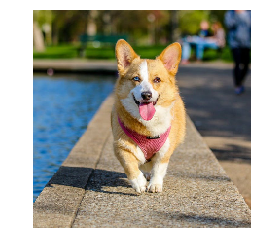

In [6]:
def load_image(path):
    img = skimage.io.imread(path)
    img = img / 255.0
    assert (0 <= img).all() and (img <= 1.0).all()
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    resized_img = skimage.transform.resize(crop_img, (224, 224), mode='reflect')
    return resized_img

# show image
img = load_image('./dog.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

## PeartMap with Stochastic Optimization

In [7]:
def pertmap_stochastic(img, penalty_weight=100.0, max_iter=500, batch_size=32, step_size=1e-2, seed=0, max_w=0.1):
    with tf.Graph().as_default():
        
        # setup VGG16
        sess = tf.Session()
        class_label = tf.placeholder(tf.int32)
        noise = tf.placeholder(tf.float32, [None, 224, 224, 3])
        w = tf.Variable(np.zeros((1, 224, 224, 3)).astype(np.float32))
        noised_image = img + noise * w
        layer = build(tf.get_default_graph(), noised_image)
        
        # Loss & Optimizer
        loss1 = tf.reduce_mean(w)
        loss2 = tf.reduce_mean(tf.maximum(0.0, layer['prob'] - tf.expand_dims(layer['prob'][:, class_label], 1)))
        loss = - loss1 + penalty_weight * loss2
        train_step = tf.train.AdamOptimizer(step_size).minimize(loss)
        
        # normal classification
        sess.run(tf.global_variables_initializer())
        x = np.zeros((1, 224, 224, 3))
        p = sess.run(layer['prob'], feed_dict={noise: x})
        c = np.argmax(p[0])
        
        # training
        res = []
        for itr in range(max_iter):
            np.random.seed(seed*max_iter+itr)
            x = np.random.rand(batch_size, 224, 224, 3) * 2 - 1
            if itr % 10 == 0:
                val_loss, val_loss1, val_loss2 = sess.run([loss, loss1, loss2], feed_dict={noise: x, class_label: c})
                v = sess.run(w)
                res.append((val_loss, val_loss1, val_loss2, v))
            sess.run(train_step, feed_dict={noise: x, class_label: c})
            sess.run(w.assign(tf.maximum(0.0, w)))
            sess.run(w.assign(tf.minimum(max_w, w)))
        
        # result
        v = sess.run(w)
        
    return c, p[0], v, res

In [8]:
c, p, v, res = pertmap_stochastic(img, penalty_weight=100.0, max_iter=500, batch_size=32, step_size=1e-2, seed=0, max_w=1.0)

## Plot Results

In [9]:
# score of PertMap
score_pertmap = - np.mean(v[0, :, :, :], axis=2)

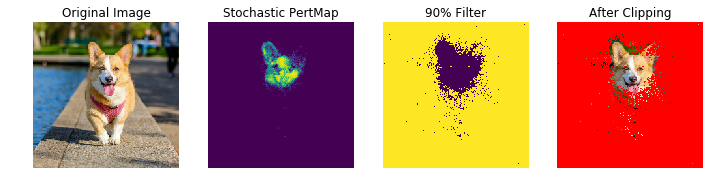

In [11]:
red = np.ones((224, 224, 3))
red[:, :, 1:] = 0

# plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')

# PertMap
plt.subplot(1, 4, 2)
plt.imshow(score_pertmap)
plt.axis('off')
plt.title('Stochastic PertMap')
plt.subplot(1, 4, 3)
filt = (score_pertmap <= np.percentile(score_pertmap, 90))
plt.imshow(filt)
plt.axis('off')
plt.title('90% Filter')
plt.subplot(1, 4, 4)
plt.imshow(img * (1 - filt)[:, :, np.newaxis] + red * filt[:, :, np.newaxis])
plt.axis('off')
plt.title('After Clipping')

plt.show()